<a href="https://colab.research.google.com/github/Abdel-Moussaoui/Auto-Encoders/blob/master/variational_autoencoder2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
Epoch 1/10
 - 5s - loss: 479.8660
Epoch 2/10
 - 3s - loss: 427.8500
Epoch 3/10
 - 3s - loss: 427.4232
Epoch 4/10
 - 3s - loss: 427.4189
Epoch 5/10
 - 3s - loss: 427.4179
Epoch 6/10
 - 3s - loss: 427.4174
Epoch 7/10
 - 3s - loss: 427.4170
Epoch 8/10
 - 3s - loss: 427.4168
Epoch 9/10
 - 3s - loss: 427.4167
Epoch 10/10
 - 3s - loss: 427.4166


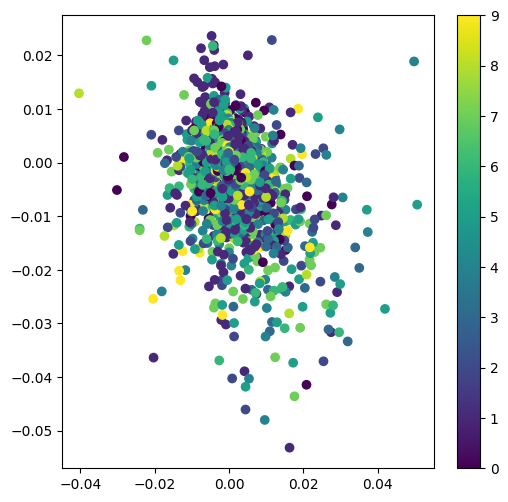

In [1]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import keras.backend as K
from keras import metrics
from keras.datasets import mnist
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

batch_size = 50
original_dim = 784
latent_dim = 2
intermediate_dim = 512
epochs = 10
epsilon_std = 1.0

# Q(z|X) -- encoder
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, activation='linear')(h)          # ****
z_log_sigma = Dense(latent_dim, activation='linear')(h)     # ****


def sampling(args):
    _z_mean, _z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return _z_mean + K.exp(_z_log_sigma / 2) * epsilon      # ****


# Sample z ~ Q(z|X)
z = Lambda(sampling)([z_mean, z_log_sigma])

# P(X|z) -- decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Overall VAE model, for reconstruction and training
vae = Model(x, x_decoded_mean)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(x, z_mean)

# Generator model, generate new data given latent variable z
decoder_input = Input(shape=(latent_dim, ))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)
    return recon + kl


vae.compile(optimizer='adam', loss=vae_loss)            # ****

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=2)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

K.clear_session()
